## Guide - pyLEnM package
# Case 3 - Water Table Estimation & Well Optimization
Welcome to the demonstration notebook where we'll estimate the groundwater table and then go over an example for well optimization to select a subset of wells to capture the spatiotemporal variability of groundwater table using the **pyLEnM** package!<br>
Let’s get started!

## Setup
Make sure to install pyLEnM from https://pypi.org/project/pylenm/ by running `pip install pylenm` in your environment terminal. Once completed, you should be able to import the package. Note: to update to the latest version of pylenm run: `pip install pylenm --upgrade`

In [ ]:
pip install pylenm

In [1]:
# Basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from math import sqrt
from sklearn.metrics import r2_score

# PyLenm
import pylenm
from pylenm import functions, usage

# GIS data layers
from pyproj import Transformer
import rasterio
import elevation
import richdem as rd

plt.rcParams["font.family"] = "Times New Roman"

## GIS Data Layers

In [2]:
# Load GIS elevation data
# dem_path = os.path.join(os.getcwd(), 'FArea-30m-DEM.tif')
# elevation.clip(bounds=(-81.686, 33.265, -81.669000, 33.28), output=dem_path)
dem_path = "data/FArea-30m-DEM.tif"
farea_dem = rd.LoadGDAL(dem_path)
farea_ras = rasterio.open(dem_path)

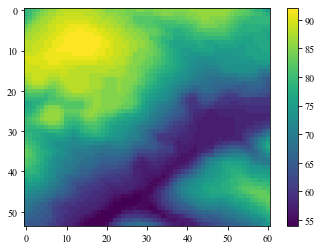

In [3]:
plt.imshow(farea_dem, interpolation='none')
plt.colorbar()
plt.show()

In [4]:
transformer = Transformer.from_crs("epsg:4326", "epsg:26917") # Latitude/Longitude to UTM
x_loc = np.zeros([farea_ras.height, farea_ras.width])
y_loc = np.zeros([farea_ras.height, farea_ras.width])
for i in range(farea_ras.height):
  for j in range(farea_ras.width):
    lon = farea_ras.xy(i,j)[0]
    lat = farea_ras.xy(i,j)[1]
    utm_x, utm_y =transformer.transform(lat,lon)
    x_loc[i,j] = utm_x
    y_loc[i,j] = utm_y

In [5]:
x_loc.shape[0], y_loc.shape[1]

(54, 61)

In [6]:
x_loc

array([[436109.09123608, 436134.95843279, 436160.8256289 , ...,
        437609.38765597, 437635.2548181 , 437661.12197965],
       [436108.88883204, 436134.75611065, 436160.62338865, ...,
        437609.19000179, 437635.05724582, 437660.92448926],
       [436108.6864295 , 436134.55379   , 436160.4211499 , ...,
        437608.99234908, 437634.85967501, 437660.72700034],
       ...,
       [436098.77054716, 436124.64191972, 436150.51329168, ...,
        437599.30916502, 437625.18050296, 437651.05184031],
       [436098.5682198 , 436124.43967423, 436150.31112805, ...,
        437599.11158573, 437624.98300553, 437650.85442474],
       [436098.36589395, 436124.23743024, 436150.10896593, ...,
        437598.9140079 , 437624.78550957, 437650.65701064]])

## Load Well Time Series Data + Preprocess

In [7]:
# Load and process well time-series data
url_1 = 'https://raw.githubusercontent.com/AurelienMeray/pylenm/master/notebooks/data/FASB_Data_thru_3Q2015_Reduced_Demo.csv'
url_2 = 'https://github.com/AurelienMeray/pylenm/blob/master/notebooks/data/FASB%20Well%20Construction%20Info.xlsx?raw=true'
concentration_data = pd.read_csv(url_1)
construction_data = pd.read_excel(url_2)
pylenm = functions(concentration_data)
pylenm.simplify_data(inplace=True)
pylenm.setConstructionData(construction_data)

Successfully imported the data!

Successfully imported the construction data!



Data summary for water table

In [8]:
WT_details = pylenm.get_analyte_details('DEPTH_TO_WATER')
WT_details

,Start Date,End Date,Date Range (days),Unique samples
Well Name,,,,
FSB 94D,1990-01-01,1990-10-08,280,4
FSB 95D,1990-01-01,1990-10-08,280,4
FSB 77,1990-01-01,2006-10-16,6132,122
FSB111C,1990-01-01,2006-10-17,6133,115
FSB105C,1990-01-01,2006-10-19,6135,127
...,...,...,...,...
FSB146D,2015-04-29,2015-09-09,133,9
FSB145D,2015-04-30,2015-09-09,132,9
FSB143D,2015-05-04,2015-09-09,128,9


Select wells that have enough and recent samples

In [9]:
n_samples = WT_details['Unique samples']
end_date = WT_details['End Date']
start_date = WT_details['Start Date']
well_names  = WT_details.index
well_enough = well_names[n_samples>20]

In [10]:
well_recent = well_names[end_date> datetime.strptime('2015-01-01', '%Y-%m-%d').date()]
well_old    = well_names[start_date< datetime.strptime('2006-01-01', '%Y-%m-%d').date()]

Temporal interpolation of the time series at equal frequency

In [11]:
wt_interp = pylenm.interpolate_wells_by_analyte('DEPTH_TO_WATER', frequency='1M', rm_outliers=True, z_threshold=3)

Select the upper aquifer wells and the wells that have enough samples

52 wells


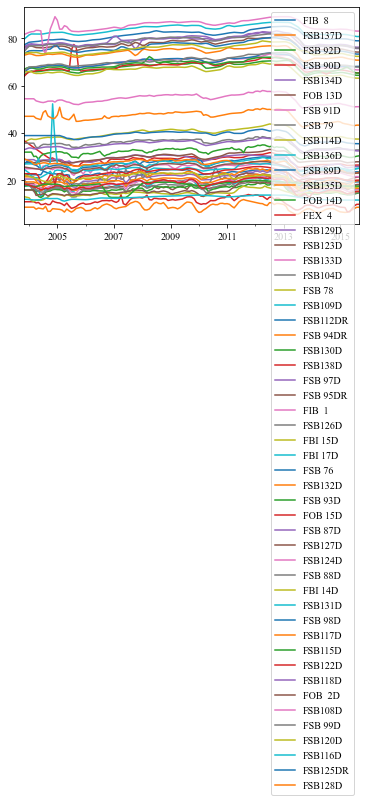

In [12]:
active = list(np.unique(pylenm.filter_by_column(pylenm.get_Construction_Data(), col='WELL_USE', equals=['ACTIVE']).index))
upper_wells = list(np.unique(pylenm.filter_by_column(pylenm.get_Construction_Data(), col='AQUIFER', equals=['UAZ_UTRAU']).index))
well_only_D = list(set(upper_wells) & set(wt_interp.columns)& set(well_enough)& set(well_recent)& set(well_old) & set(active))
wt_interp = wt_interp[well_only_D]
wt_interp.plot()
print(wt_interp.shape[1], "wells")

Let's remove the 'bad' time series wells

49 wells


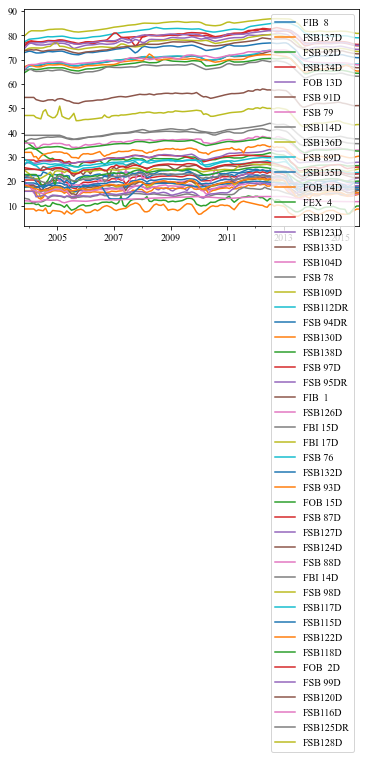

In [13]:
bad_ones = ['FSB108D', 'FSB131D', 'FSB 90D']
wt_interp = wt_interp.drop(columns=bad_ones)
wt_interp.plot()
print(wt_interp.shape[1], "wells")

In [14]:
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

# Convert to meters
wt_interp = wt_interp * 0.3048

<AxesSubplot:>

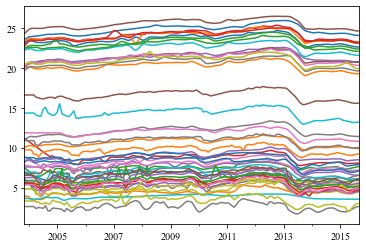

In [15]:
wt_interp.plot(legend=False)

## Well Location Data

In [16]:
well_info = pylenm.get_Construction_Data()

Match the well indecies between the time series and locations

In [17]:
shared_wells = list(set(well_info.index) & set(wt_interp.columns))
wt_interp = wt_interp[shared_wells]
# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

well_info = well_info.T[shared_wells]
# Reorder columns to be in alphabetical order
well_info = well_info.reindex(sorted(well_info.columns), axis=1)
well_info = well_info.T

In [18]:
transformer = Transformer.from_crs("epsg:4326", "epsg:26917") # Latitude/Longitude to UTM
UTM_x, UTM_y = transformer.transform(well_info.LATITUDE, well_info.LONGITUDE)

Take out the ground-surface elevation, and compute the water table elevation

In [19]:
elev = well_info.REFERENCE_ELEVATION
elev.index = well_info.index
elev = elev.T
elev = elev * 0.3048 # convert to meters

# Now this is the water table elevation (GROUND_ELEVATION - DEPTH_TO_WATER)
wt_interp = elev.values - wt_interp

# Reorder columns to be in alphabetical order
wt_interp = wt_interp.reindex(sorted(wt_interp.columns), axis=1)

In [20]:
X = np.vstack((UTM_x,UTM_y, elev.values)).T
X = pd.DataFrame(X, columns=['Easting', 'Northing', 'Elevation'])

In [21]:
wt_interp

,FBI 14D,FBI 15D,FBI 17D,FEX 4,FIB 1,FIB 8,FOB 2D,FOB 13D,FOB 14D,FOB 15D,FSB 76,FSB 78,FSB 79,FSB 87D,FSB 88D,FSB 89D,FSB 91D,FSB 92D,FSB 93D,FSB 94DR,FSB 95DR,FSB 97D,FSB 98D,FSB 99D,FSB104D,FSB109D,FSB112DR,FSB114D,FSB115D,FSB116D,FSB117D,FSB118D,FSB120D,FSB122D,FSB123D,FSB124D,FSB125DR,FSB126D,FSB127D,FSB128D,FSB129D,FSB130D,FSB132D,FSB133D,FSB134D,FSB135D,FSB136D,FSB137D,FSB138D
2003-11-30,61.585542,60.901512,60.688816,59.499998,62.295746,62.437965,62.008508,60.753514,61.54043,61.662636,66.158264,63.070418,60.298687,64.636008,65.925815,65.802441,65.140418,64.549193,63.876877,63.5127,63.458979,63.877358,64.325028,65.016438,60.816631,65.092749,61.987787,65.942765,58.278674,58.259937,61.522594,64.162933,63.052715,60.804025,64.382033,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2003-12-31,61.68838,60.966745,60.908931,59.714151,62.295746,62.437965,62.053669,60.753514,61.54043,61.662636,66.010134,63.038397,60.716502,64.34876,65.651149,65.548903,64.868837,64.369604,63.725961,63.419736,63.389256,63.726152,64.128033,64.646695,61.160942,64.824187,61.613088,65.768314,58.222896,58.270701,61.661436,64.032542,63.024023,60.86141,64.275789,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2004-01-31,61.792904,61.033048,61.132654,59.931814,62.295746,62.437965,62.099569,60.753514,61.54043,61.662636,65.844252,62.982612,60.976896,64.127094,65.420851,65.32736,64.650485,64.161211,63.624637,63.330954,63.313493,63.586035,63.97668,64.363922,61.42252,64.570394,61.708881,65.592494,58.200269,58.299911,61.755465,63.929931,62.977902,60.928014,64.192771,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2004-02-29,61.894056,61.388625,61.536334,60.142457,62.295746,62.437965,62.143989,60.753514,61.54043,61.662636,65.806033,63.031672,61.325178,64.083765,65.3796,65.27604,64.567335,64.078394,63.673784,63.36211,63.270753,63.537774,63.942928,64.303995,61.597263,64.439188,61.845444,65.511407,58.252331,58.342546,61.874895,63.945146,62.946943,61.024165,64.196779,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,61.848034,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
2004-03-31,61.995208,61.519272,61.782802,60.353099,62.295746,62.437965,62.188409,60.753514,61.54043,61.662636,65.782366,63.19133,61.82782,64.06417,65.3796,65.236236,64.595427,64.121937,63.772482,63.469266,63.373528,63.597536,63.93567,64.293835,61.857455,64.445682,62.002563,65.573977,58.338285,58.356137,62.191392,64.045713,62.984674,61.174063,64.281885,62.467709,62.513127,62.210189,60.43472,61.615037,59.878239,62.412372,61.936238,61.625983,61.815591,61.169124,61.083535,59.345296,60.97678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-05-31,63.285343,60.447936,60.786264,62.670255,63.191666,63.304045,62.7888,60.201692,62.184501,62.519705,65.495754,63.730463,60.699352,64.215676,65.259585,65.114059,64.736107,64.432375,63.814989,63.993854,63.895972,63.966133,64.191315,64.387516,62.576891,64.596745,62.972684,65.451466,58.27776,58.3692,63.440509,64.146072,63.316521,61.975703,64.251424,63.389697,63.50045,63.08743,60.27462,62.69788,60.895562,62.53409,62.770066,62.516697,62.739319,62.203465,62.120734,59.840528,62.273277
2015-06-30,63.342973,60.36405,60.716541,62.653654,63.266441,63.334359,62.7888,60.089862,62.164301,62.509489,65.562755,63.783831,60.637132,64.299427,65.317688,65.094195,64.809207,64.503886,64.052269,64.053446,63.963502,64.042434,64.264359,64.469785,62.585908,64.661983,62.979246,65.485581,58.27776,58.3692,63.486844,64.209637,63.37214,61.898407,64.213394,63.4681,63.525884,63.121441,59.985238,62.785176,60.852908,62.527266,62.741723,62.428665,62.67895

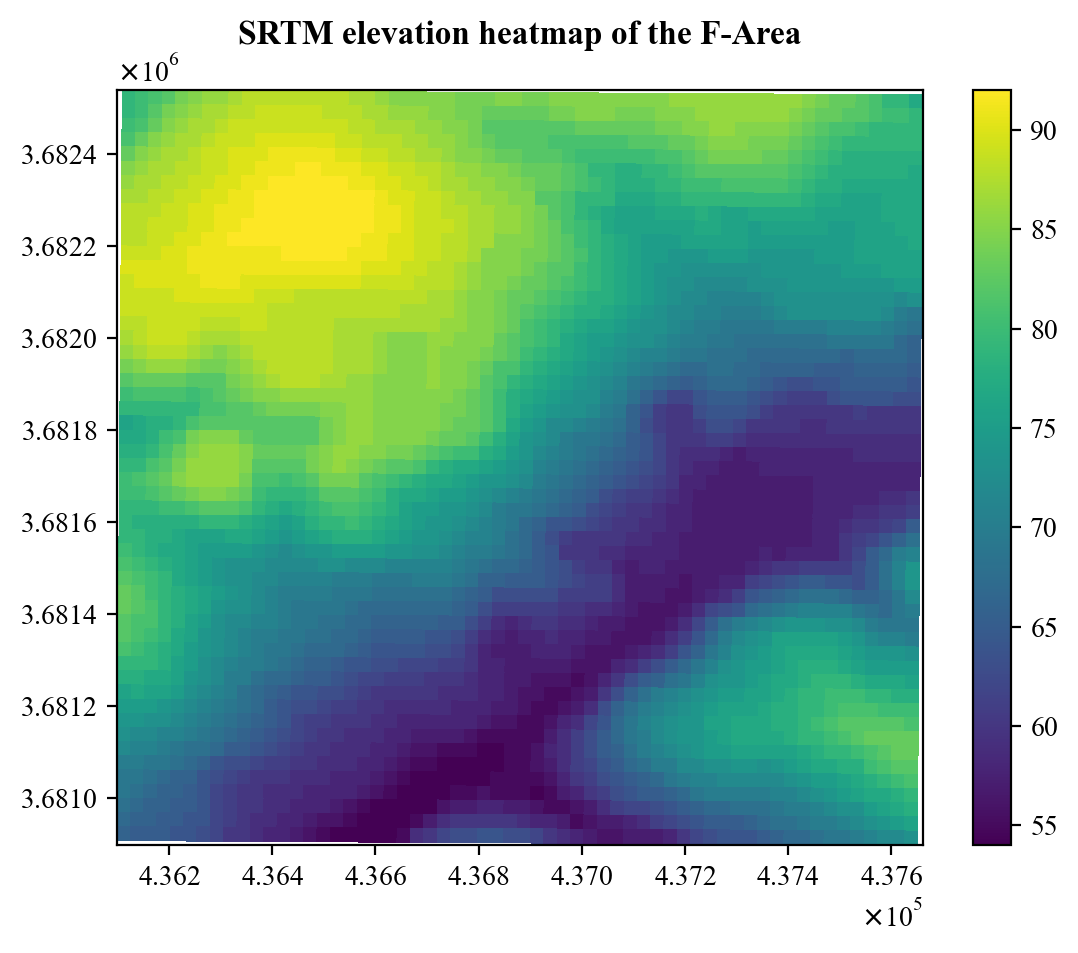

In [41]:
# Plotting the map
plt.figure( dpi=200, figsize=(6.5,5))
map_ = plt.pcolor(x_loc, y_loc , farea_dem)
# plt.scatter(UTM_x, UTM_y, c='#900C3F')
plt.ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
plt.colorbar(map_)
plt.title('SRTM elevation heatmap of the F-Area',y=1.04, fontweight='bold')
plt.show()

In [23]:
wt_interp.shape

(143, 49)

In [24]:
XX = np.vstack([x_loc.flatten(), y_loc.flatten(), farea_dem.flatten()]).T
XX = pd.DataFrame(XX, columns=['Easting', 'Northing', 'Elevation'])

In [25]:
dateRanges = wt_interp.index
values = {}
for date in dateRanges:
    values[date] = np.array(wt_interp.loc[date])

currentDate = dateRanges[20]
y = values[currentDate]
print(currentDate)

2005-07-31 00:00:00


In [26]:
usage.get_FunctionDescription("interpolate_topo")


interpolate_topo (X, y, xx, ft=['Elevation'], regression='linear', model=None, smooth=True):
Description: 
    Interpolate the water table as a function of topographic metrics using Gaussian Process. Uses regression to generate trendline adds the values to the GP map.
Parameters:
    X (dataframe): training values. Must include "Easting" and "Northing" columns.
    y (array of floats): array of size (number of wells) where each value corresponds to a concentration value at a well.
    xx (array of floats): prediction locations
    ft (list of stings): feature names to train on
    regression (string): choice between 'linear' for linear regression, 'rf' for random forest regression, 'ridge' for ridge regression, or 'lasso' for lasso regression.
    model (GP model): model to fit
    smooth (bool): flag to toggle WhiteKernel on and off



In [27]:
y_map, r_map, residuals, lr_trend = pylenm.interpolate_topo(X, y, XX, ft=['Elevation'], regression='linear', smooth=True)

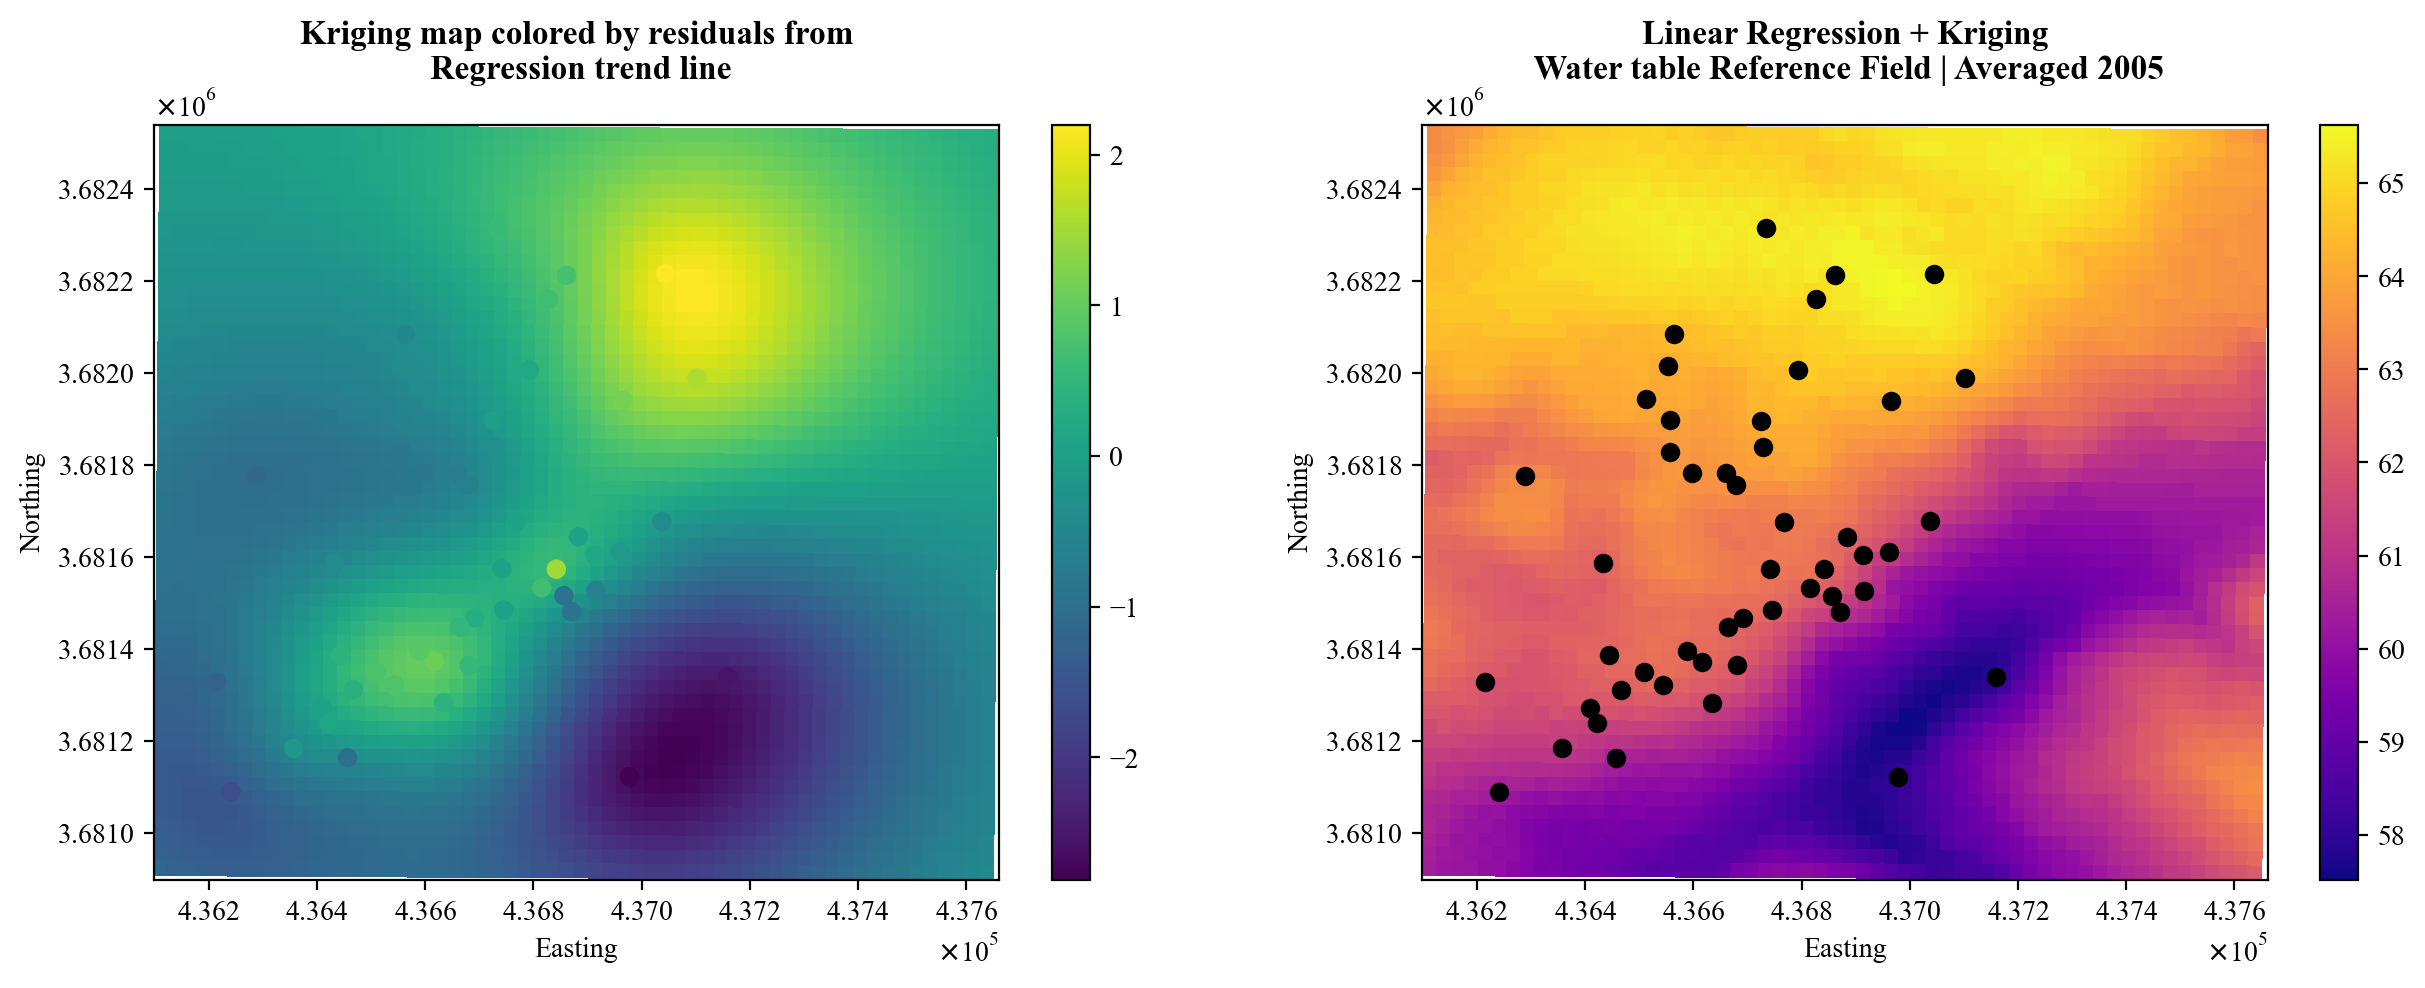

In [31]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=200)
xx = np.array(XX)
titles = ["Kriging map colored by residuals from\n Regression trend line", str("Linear Regression + Kriging\n Water table Reference Field | {}".format("Averaged 2005"))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                r_map.reshape(x_loc.shape))
fig.colorbar(map_0, ax=ax[0])
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax[1])
colors=[residuals, 'black']
for i in range(2):
    ax[i].scatter(X.iloc[:,0], X.iloc[:,1], c=colors[i], alpha=1)
    ax[i].set_xlabel("Easting")
    ax[i].set_ylabel("Northing")
    ax[i].set_title(titles[i],y=1.04, fontweight='bold')
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
fig.show()

In [32]:
# GETS APPROXIMATE WT VALUE IN THE XX GRID
def get_approx_predictions(X, y_map, XX):
    X_approx, y_approx = [],[]
    for i in range(X.shape[0]):
        x1, y1 = X.iloc[i].Easting, X.iloc[i].Northing # ACTUAL POINT
        abs_east = np.abs(XX.Easting-x1)
        abs_north= np.abs(XX.Northing-y1)
        c = np.maximum(abs_north,abs_east)
        index = np.argmin(c)
        XX.iloc[index].Easting, XX.iloc[index].Northing
        X_approx.append([XX.iloc[index].Easting, XX.iloc[index].Northing, XX.iloc[index].Elevation])
        y_approx.append(y_map[index])
    X_approx = pd.DataFrame(X_approx, columns=['Easting', 'Northing', 'Elevation'])
    return X_approx, y_approx

In [33]:
# Try both Linear regression and random forest for spatial estimation of WT
y_map_lr, r_map, residuals, lr_trend = pylenm.interpolate_topo(X, y, XX, ft=['Elevation'], regression='linear', smooth=True)
y_map_rf, r_map, residuals, lr_trend = pylenm.interpolate_topo(X, y, XX, ft=['Elevation'], regression='rf', smooth=True)

In [34]:
X_approx, y_approx_lr = get_approx_predictions(X, y_map_lr, XX)
X_approx, y_approx_rf = get_approx_predictions(X, y_map_rf, XX)

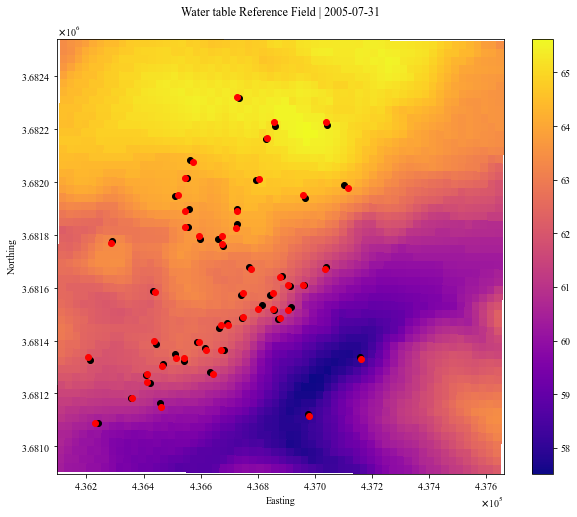

In [42]:
# Plot all result details
fig, ax = plt.subplots(1,1,figsize=(10,8))
xx = np.array(XX)
titles = [str("Water table Reference Field | {}".format(currentDate.date()))]
map_1 = ax.pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map_lr.reshape(x_loc.shape), 
                cmap='plasma')
fig.colorbar(map_1, ax=ax)
ax.scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1) # Real point
ax.scatter(X_approx.iloc[:,0], X_approx.iloc[:,1], c='red', alpha=1) # Approximate point
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title(titles[0],y=1.04)
ax.ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
fig.show()

MSE LR:  0.13390912275420938
MSE RF:  0.9442936796706551
R^2 LR:  0.9493461647604358
R^2 RF:  0.6428018085399965
[0.    1.524 3.047 4.571 6.094 7.618]


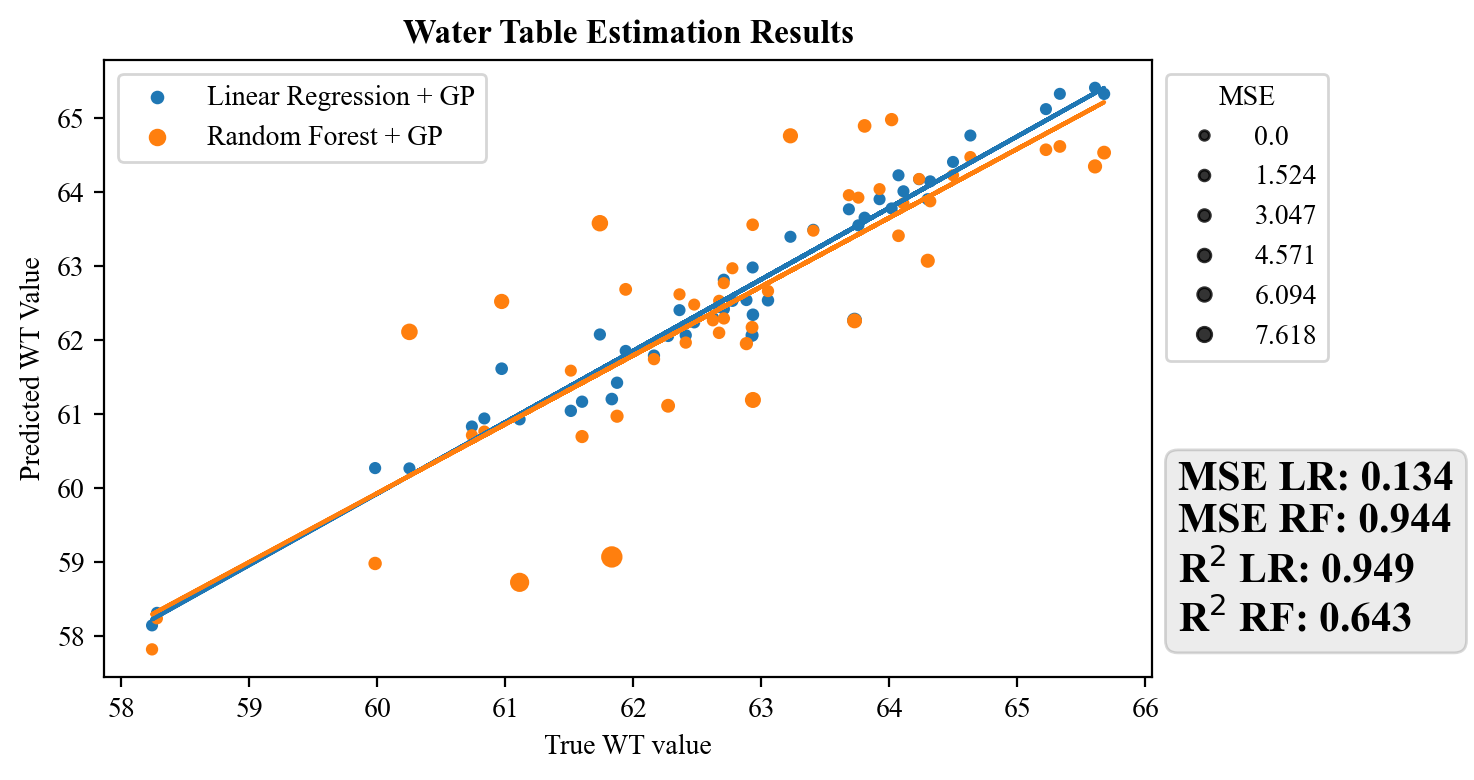

<Figure size 1200x800 with 0 Axes>

In [45]:
fig, ax = plt.subplots(dpi=200)
plt.rcParams["legend.loc"] = 'upper left'
print("MSE LR: ",pylenm.mse(y, y_approx_lr))
print("MSE RF: ",pylenm.mse(y, y_approx_rf))

print("R^2 LR: ",r2_score(y, y_approx_lr))
print("R^2 RF: ",r2_score(y, y_approx_rf))
text = "MSE LR: {:.3f}".format(pylenm.mse(y, y_approx_lr)) + "\n" + "MSE RF: {:.3f}".format(pylenm.mse(y, y_approx_rf)) + "\n" + "R{} LR: {:.3f}".format('$^{2}$', r2_score(y, y_approx_lr)) + "\n" + "R{} RF: {:.3f}".format('$^{2}$', r2_score(y, y_approx_rf))
plt.figure( dpi=200)
ax.set_title('Water Table Estimation Results',fontweight='bold')
ax.set_xlabel('True WT value')
ax.set_ylabel('Predicted WT Value')

err_lr, err_rf = [], []
for i in range(len(y)):
    err_lr.append(pylenm.mse([y[i]], [y_approx_lr[i]]))
    err_rf.append(pylenm.mse([y[i]], [y_approx_rf[i]]))
minmaxscaler=MinMaxScaler()
minmaxscaler.fit_transform(np.array(err_lr).reshape(-1,1)).flatten().tolist()
minmaxscaler.fit_transform(np.array(err_rf).reshape(-1,1)).flatten().tolist()

err_lr_s = [(x+5)**1.5 for x in err_lr]
err_rf_s = [(x+5)**1.5 for x in err_rf]
scatter1 = ax.scatter(y, y_approx_lr, label = "Linear Regression + GP", s=err_lr_s)
scatter2 = ax.scatter(y, y_approx_rf, label = "Random Forest + GP", s=err_rf_s)
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
fig.tight_layout()
fig.text(1.025, 0.06, text, transform=ax.transAxes, fontsize=15, fontweight='bold', verticalalignment='bottom', bbox=props)

m_lr, b_lr = np.polyfit(y.astype("float64"), np.array(y_approx_lr).flatten(), 1)
m_rf, b_rf = np.polyfit(y.astype("float64"), np.array(y_approx_rf).flatten(), 1)

legend1 = ax.legend()
ax.add_artist(legend1)
# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter2.legend_elements(prop="sizes", alpha=0.8)
labels=np.round(np.linspace(min(np.array(err_lr).min(),np.array(err_rf).min()), max(np.array(err_lr).max(),np.array(err_rf).max()) ,6),3)
print(labels)
legend2 = ax.legend(handles, labels, title="MSE", bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

ax.plot(y, m_lr*y + b_lr)
ax.plot(y, m_rf*y + b_rf)

MSE LR:  0.13390912275420938
MSE RF:  0.9442936796706551
R^2 LR:  0.9493461647604358
R^2 RF:  0.6428018085399965


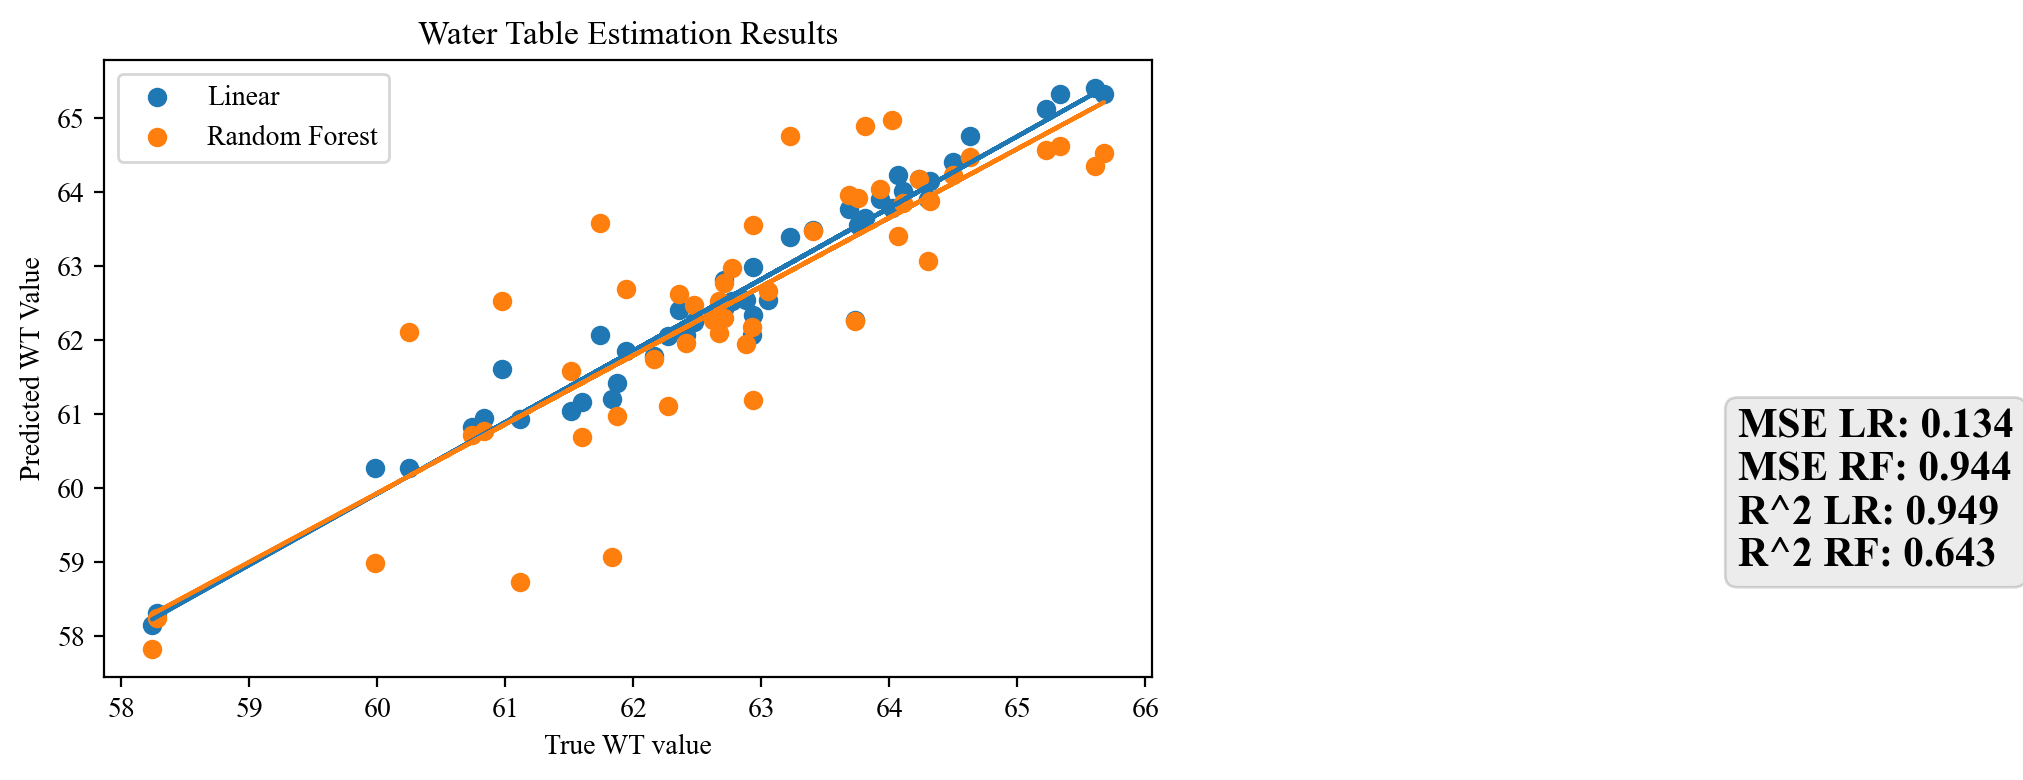

In [44]:
print("MSE LR: ",pylenm.mse(y, y_approx_lr))
print("MSE RF: ",pylenm.mse(y, y_approx_rf))

print("R^2 LR: ",r2_score(y, y_approx_lr))
print("R^2 RF: ",r2_score(y, y_approx_rf))
text = "MSE LR: {:.3f}".format(pylenm.mse(y, y_approx_lr)) + "\n" + "MSE RF: {:.3f}".format(pylenm.mse(y, y_approx_rf)) + "\n" + "R^2 LR: {:.3f}".format(r2_score(y, y_approx_lr)) + "\n" + "R^2 RF: {:.3f}".format(r2_score(y, y_approx_rf))
plt.figure( dpi=200)
plt.title('Water Table Estimation Results')
plt.xlabel('True WT value')
plt.ylabel('Predicted WT Value')

plt.scatter(y, y_approx_lr, label = "Linear")
plt.scatter(y, y_approx_rf, label = "Random Forest" )
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
plt.tight_layout()
plt.text(1.55, 0.15, text, transform=ax.transAxes, fontsize=15, fontweight='bold', verticalalignment='bottom', bbox=props)

m_lr, b_lr = np.polyfit(y.astype("float64"), np.array(y_approx_lr).flatten(), 1)
m_rf, b_rf = np.polyfit(y.astype("float64"), np.array(y_approx_rf).flatten(), 1)
plt.plot(y, m_lr*y + b_lr)
plt.plot(y, m_rf*y + b_rf)

plt.legend()

As we can see by the MSE and the R^2, linear regression does a better job at estimating the WT. <br>
Now lets perform Leave-One-Out Cross Validation to see the difference in performance and get a more realistic view of the data.

In [35]:
X_approx_loo, y_approx_loo_lr, y_approx_loo_rf = [],[],[]

loo = LeaveOneOut()
print("NUMBER OF SPLITS: ", loo.get_n_splits(X))
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_map_train_lr, r_map, residuals, lr_trend = pylenm.interpolate_topo(X_train, y_train, XX, ft=['Elevation'], regression='linear', smooth=True)
    y_map_train_rf, r_map, residuals, lr_trend = pylenm.interpolate_topo(X_train, y_train, XX, ft=['Elevation'], regression='rf', smooth=True)
    X_approx_test_lr, y_approx_test_lr = get_approx_predictions(X_test, y_map_train_lr, XX)
    X_approx_test_rf, y_approx_test_rf = get_approx_predictions(X_test, y_map_train_rf, XX)
    X_approx_loo.append(X_approx_test_lr.values.tolist()[0])
    y_approx_loo_lr.append(y_approx_test_lr)
    y_approx_loo_rf.append(y_approx_test_rf)
X_approx_loo = pd.DataFrame(X_approx_loo, columns=['Easting', 'Northing', 'Elevation'])

NUMBER OF SPLITS:  49


MSE LR:  0.3512071573999222
MSE RF:  1.210141241957598
R^2 LR:  0.8671487862813877
R^2 RF:  0.542239588864793
[1.000e-03 1.670e+00 3.339e+00 5.008e+00 6.677e+00 8.347e+00]


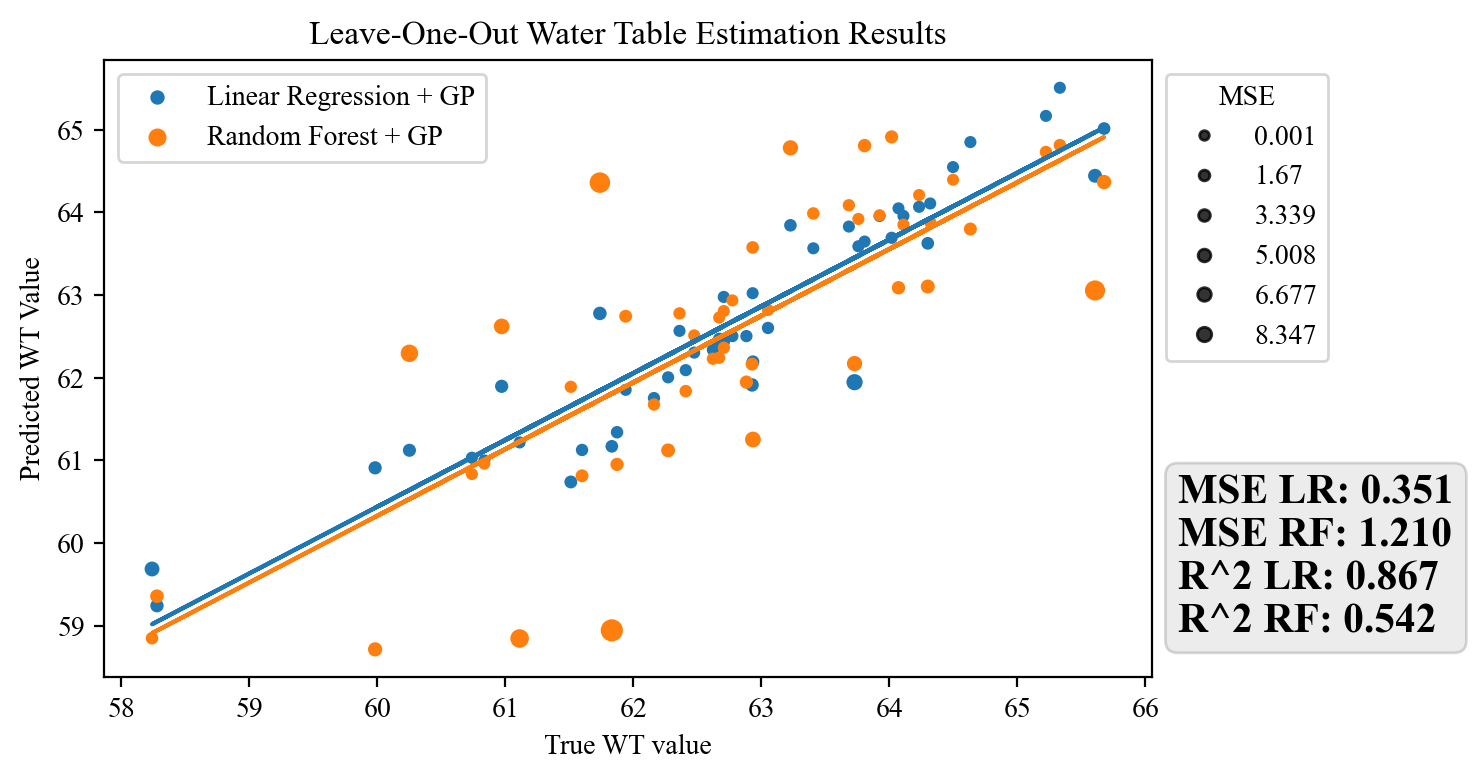

<Figure size 1200x800 with 0 Axes>

In [36]:
fig, ax = plt.subplots(dpi=200)
plt.rcParams["legend.loc"] = 'upper left'
print("MSE LR: ",pylenm.mse(y, y_approx_loo_lr))
print("MSE RF: ",pylenm.mse(y, y_approx_loo_rf))

print("R^2 LR: ",r2_score(y, y_approx_loo_lr))
print("R^2 RF: ",r2_score(y, y_approx_loo_rf))
text = "MSE LR: {:.3f}".format(pylenm.mse(y, y_approx_loo_lr)) + "\n" + "MSE RF: {:.3f}".format(pylenm.mse(y, y_approx_loo_rf)) + "\n" + "R^2 LR: {:.3f}".format(r2_score(y, y_approx_loo_lr)) + "\n" + "R^2 RF: {:.3f}".format(r2_score(y, y_approx_loo_rf))
plt.figure( dpi=200)
ax.set_title('Leave-One-Out Water Table Estimation Results')
ax.set_xlabel('True WT value')
ax.set_ylabel('Predicted WT Value')

err_lr, err_rf = [], []
for i in range(len(y)):
    err_lr.append(pylenm.mse([y[i]], [y_approx_loo_lr[i]]))
    err_rf.append(pylenm.mse([y[i]], [y_approx_loo_rf[i]]))
minmaxscaler=MinMaxScaler()
minmaxscaler.fit_transform(np.array(err_lr).reshape(-1,1)).flatten().tolist()
minmaxscaler.fit_transform(np.array(err_rf).reshape(-1,1)).flatten().tolist()

err_lr_s = [(x+5)**1.5 for x in err_lr]
err_rf_s = [(x+5)**1.5 for x in err_rf]
scatter1 = ax.scatter(y, y_approx_loo_lr, label = "Linear Regression + GP", s=err_lr_s)
scatter2 = ax.scatter(y, y_approx_loo_rf, label = "Random Forest + GP", s=err_rf_s)
props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
fig.tight_layout()
fig.text(1.025, 0.06, text, transform=ax.transAxes, fontsize=15, fontweight='bold', verticalalignment='bottom', bbox=props)

m_lr, b_lr = np.polyfit(y.astype("float64"), np.array(y_approx_loo_lr).flatten(), 1)
m_rf, b_rf = np.polyfit(y.astype("float64"), np.array(y_approx_loo_rf).flatten(), 1)

legend1 = ax.legend()
ax.add_artist(legend1)
# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter2.legend_elements(prop="sizes", alpha=0.8)
labels=np.round(np.linspace(min(np.array(err_lr).min(),np.array(err_rf).min()), max(np.array(err_lr).max(),np.array(err_rf).max()) ,6),3)
print(labels)
legend2 = ax.legend(handles, labels, title="MSE", bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

# plt.errorbar(y, np.array(y_approx_loo_lr).flatten(),yerr=err)
ax.plot(y, m_lr*y + b_lr)
ax.plot(y, m_rf*y + b_rf)

Similarly to before, linear regression is still better than random forest.

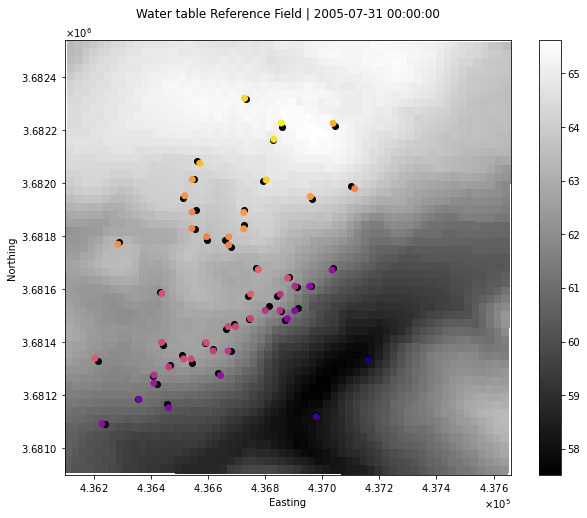

In [36]:
# Plot all result details
fig, ax = plt.subplots(1,1,figsize=(10,8))
xx = np.array(XX)
titles = [str("Water table Reference Field | {}".format(currentDate))]
map_1 = ax.pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map_lr.reshape(x_loc.shape), 
                cmap='gray')
fig.colorbar(map_1, ax=ax)
ax.scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=1) # Real point
ax.scatter(X_approx_loo.iloc[:,0], X_approx_loo.iloc[:,1], c=y_approx_loo_lr, cmap='plasma', alpha=1) # Approximate point on Grid
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title(titles[0],y=1.04)
ax.ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
fig.show()

## Well optimization

Select initial wells + determine its index number respectively

In [37]:
initial_wells = ['FSB 95DR','FSB130D','FSB 79', 'FSB 97D', 'FSB126D']
well_list = list(wt_interp.columns)
initial_idx = []
for i in initial_wells:
  initial_idx.append(well_list.index(i))
initial_indices = initial_idx.copy()
print(initial_idx)

[20, 41, 12, 21, 37]


In [38]:
usage.get_FunctionDescription('get_Best_Wells')


get_Best_Wells (X, y, xx, ref, initial, max_wells, ft=['Elevation'], regression='linear', verbose=True, smooth=True, model=None):
Description: 
    Optimization function to select a subset of wells as to minimizes the MSE from a reference map
Parameters:
    X (array): array of dimension (number of wells, 2) where each element is a pair of UTM coordinates.
    y (array of floats): array of size (number of wells) where each value corresponds to a concentration value at a well.
    xx (array of floats): prediction locations
    ref (array): reference values for xx locations
    max_wells (int): number of wells to optimize for
    ft (list of stings): feature names to train on
    regression (string): choice between 'linear' for linear regression, 'rf' for random forest regression, 'ridge' for ridge regression, or 'lasso' for lasso regression.
    initial (list of ints): indices of wells as the starting wells for optimization
    verbose (bool): flag to toggle details of the well selecti

Run well selection optimization using:<br>
- y_map_lr as the reference since it gave us the smallest MSE and the best R^2.
- 'FSB 95DR','FSB130D','FSB 79', 'FSB 97D', and 'FSB126D' as the starting wells
- a maximum of 20 wells

In [39]:
max_wells = 35
selected_wells_idx, errors = pylenm.get_Best_Wells(X=X[['Easting','Northing']], y=y, xx=XX[['Easting','Northing']], ref=y_map_lr, initial=initial_idx, max_wells=max_wells, ft=['Elevation'], regression='linear')

# of wells to choose from:  44
Selected well: 39 with a MSE error of 2.522283912125532

# of wells to choose from:  43
Selected well: 25 with a MSE error of 1.7008904314663698

# of wells to choose from:  42
Selected well: 32 with a MSE error of 1.5790400588804137

# of wells to choose from:  41
Selected well: 46 with a MSE error of 1.5041160391971282

# of wells to choose from:  40
Selected well: 45 with a MSE error of 1.4926718881974388

# of wells to choose from:  39
Selected well: 30 with a MSE error of 1.4901916791462435

# of wells to choose from:  38
Selected well: 33 with a MSE error of 1.4896529972504027

# of wells to choose from:  37
Selected well: 13 with a MSE error of 1.496607228157269

# of wells to choose from:  36
Selected well: 23 with a MSE error of 1.5000952074278664

# of wells to choose from:  35
Selected well: 42 with a MSE error of 1.4947158898128468

# of wells to choose from:  34
Selected well: 22 with a MSE error of 1.488966080803789

# of wells to choose fro

Text(0, 0.5, 'Error (MSE)')

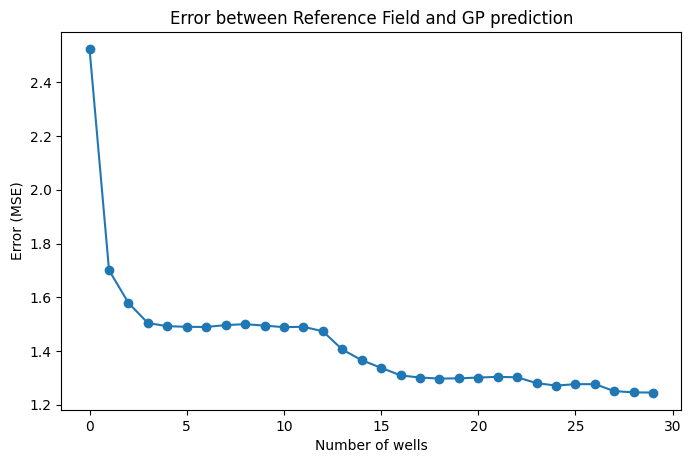

In [ ]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(pd.Series(errors[0:31]), marker='o')
plt.title('Error between Reference Field and GP prediction')
plt.xlabel('Number of wells')
plt.ylabel('Error (MSE)')

In [41]:
# Interpolate using selected wells 
pred_map, r_map, residuals, lr_trend = pylenm.interpolate_topo(X.iloc[selected_wells_idx], y[selected_wells_idx], XX, ft=['Elevation'], regression='linear', smooth=True)

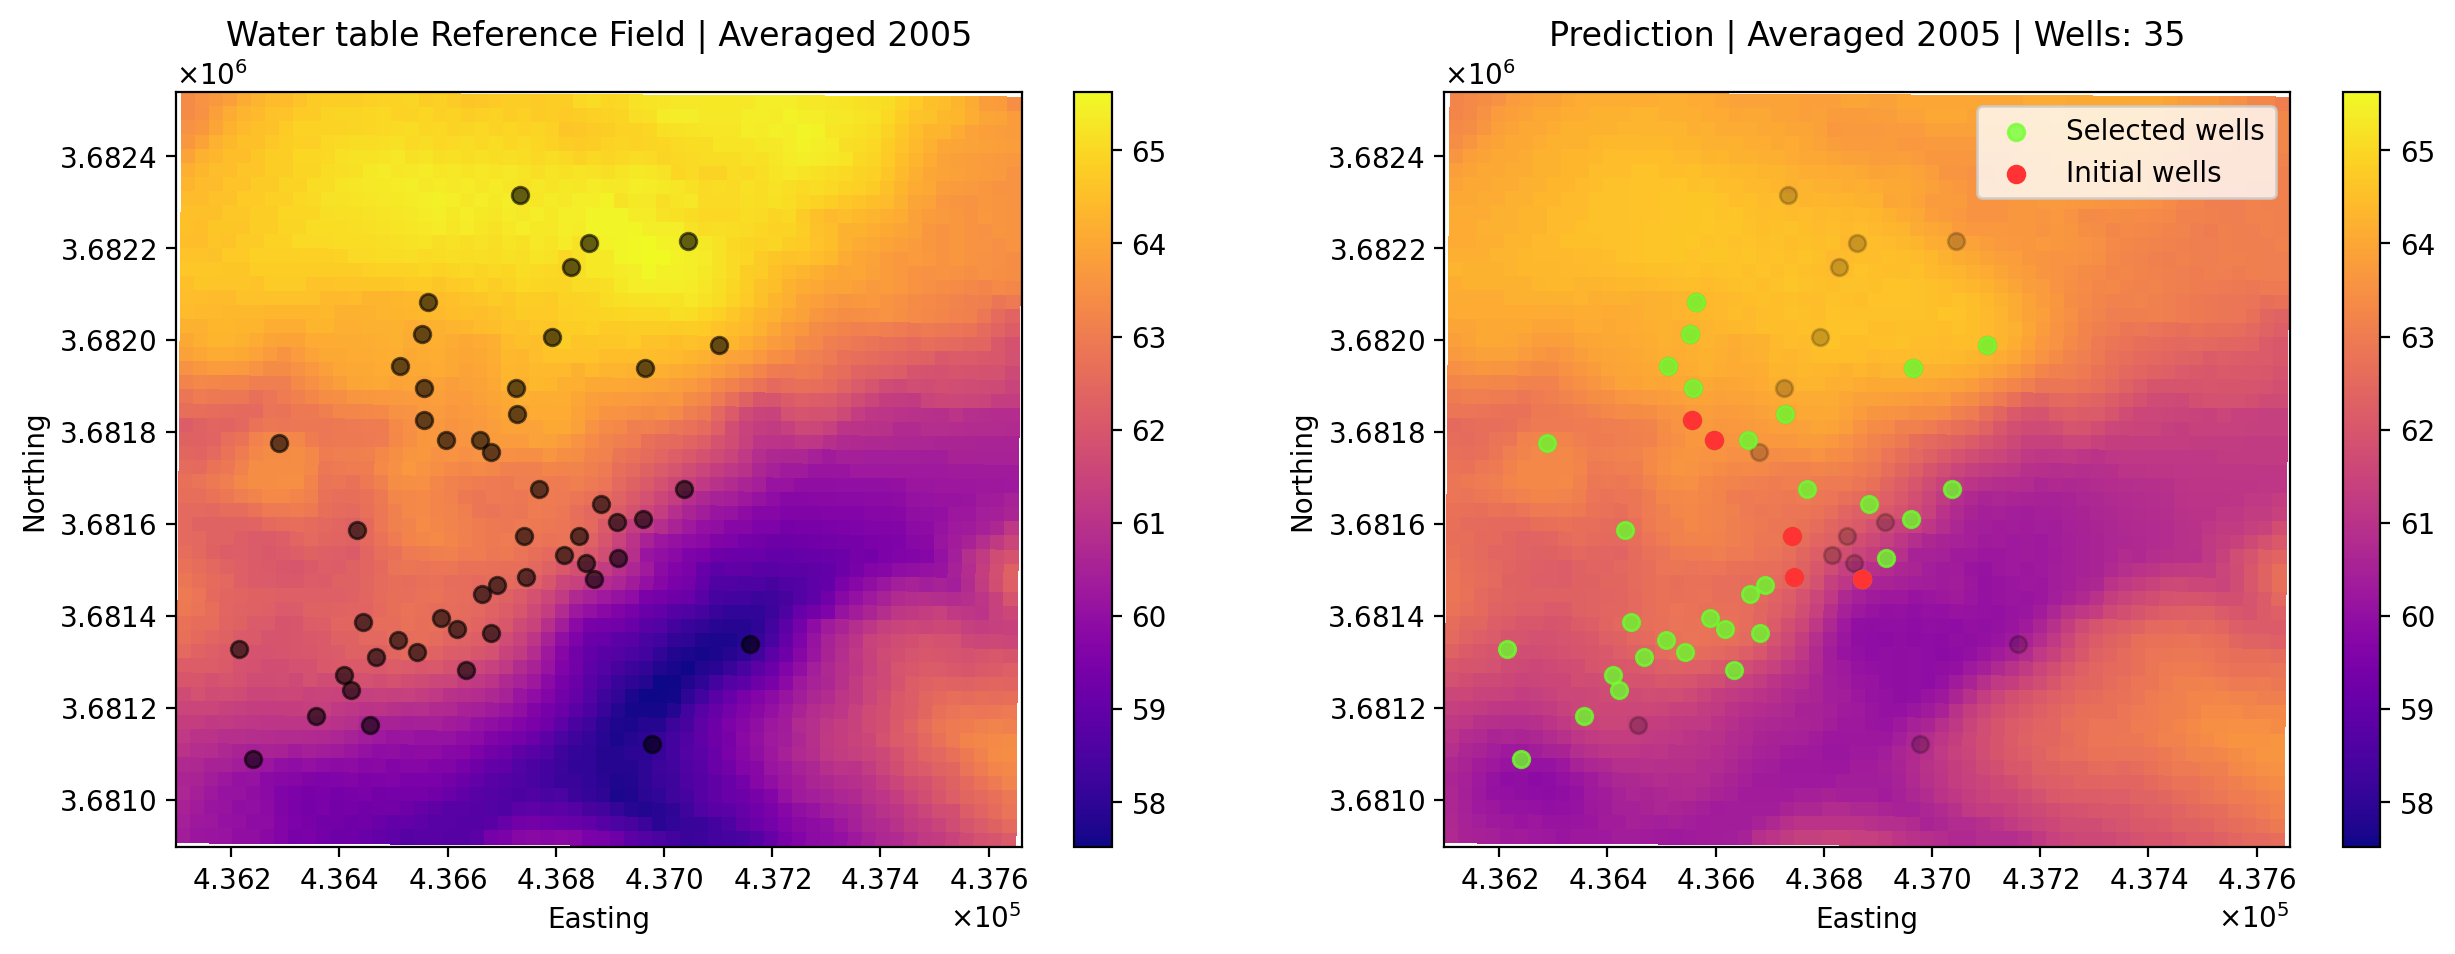

In [42]:
# Plot all result details
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=200)
xx = np.array(XX)
titles = [str("Water table Reference Field | {}".format("Averaged 2005")), str('Prediction | {} | Wells: {}'.format("Averaged 2005", max_wells))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape),
                cmap='plasma')
ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.6)
fig.colorbar(map_0, ax=ax[0])
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                pred_map.reshape(x_loc.shape),
                cmap='plasma',
                vmin=y_map.min(), vmax=y_map.max())
ax[1].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.2)
ax[1].scatter(X.iloc[selected_wells_idx,0], X.iloc[selected_wells_idx,1], c='#75FF33', alpha=0.8, label='Selected wells')
ax[1].scatter(X.iloc[initial_indices,0], X.iloc[initial_indices,1], c='#FF3333', alpha=1, label='Initial wells')
ax[1].legend()
fig.colorbar(map_1, ax=ax[1])
for i in range(2):
    ax[i].set_xlabel("Easting")
    ax[i].set_ylabel("Northing")
    ax[i].set_title(titles[i],y=1.04)
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
fig.show()

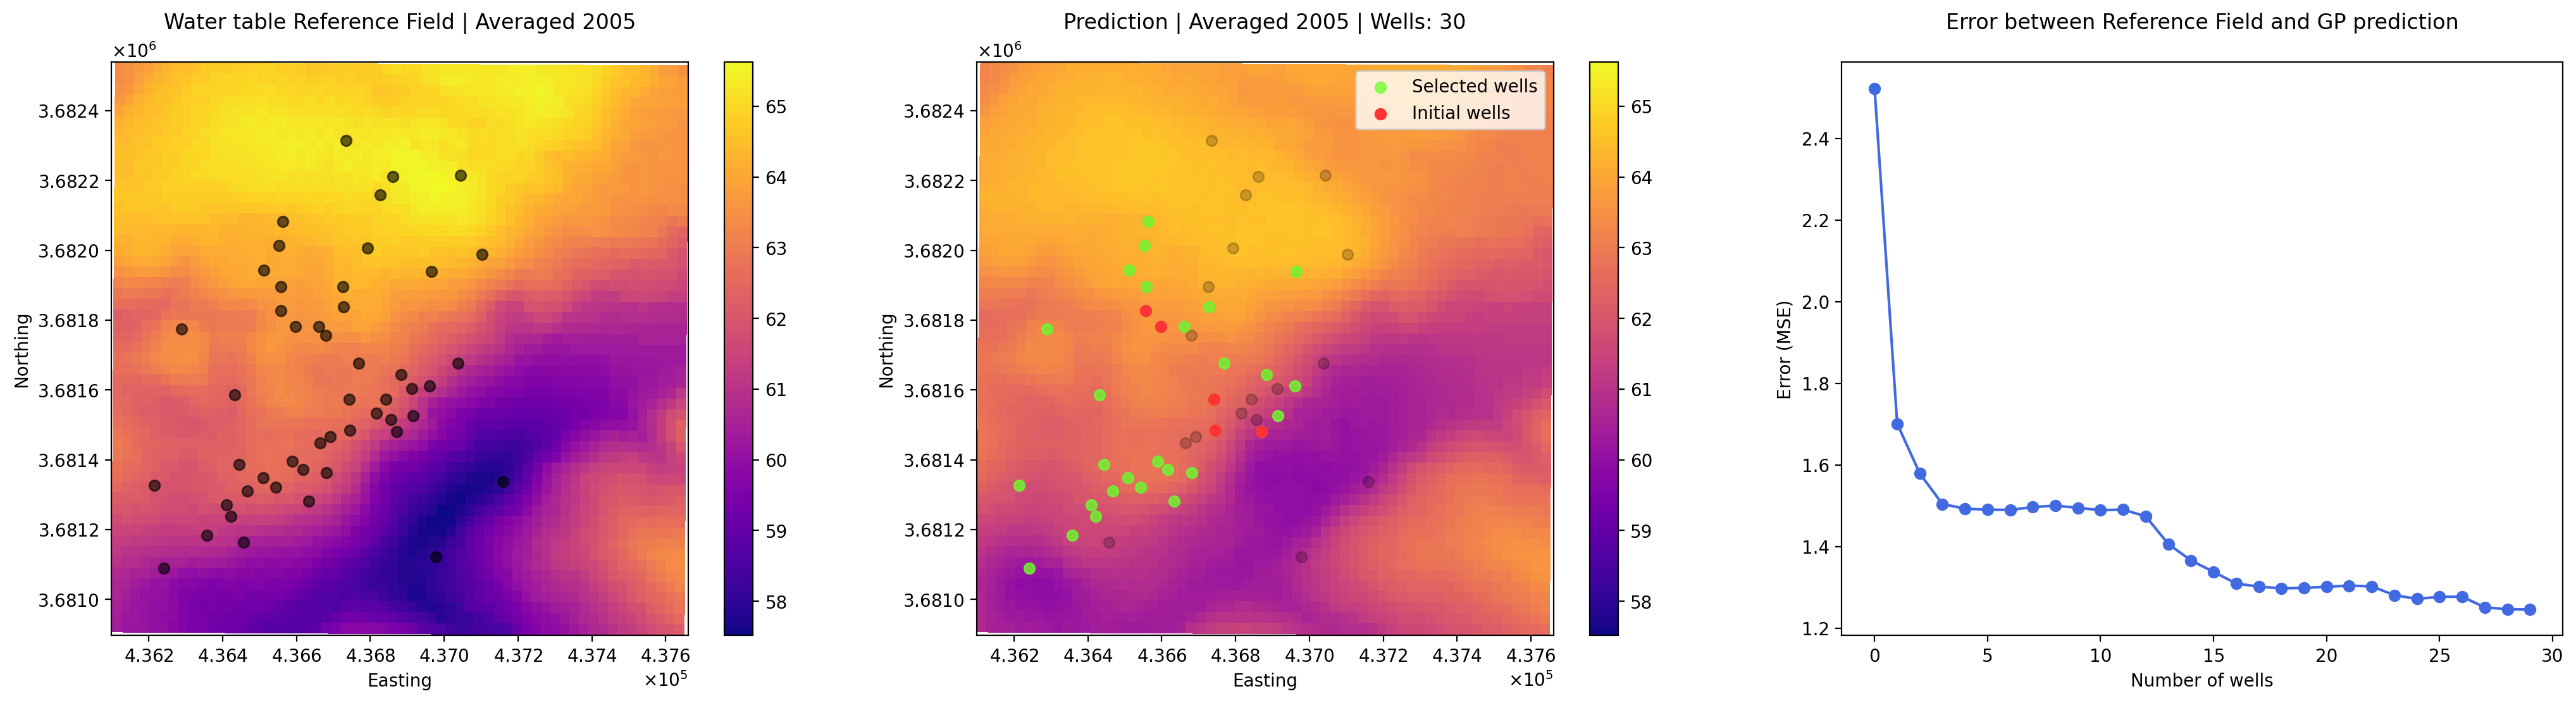

In [43]:
# Plot all result details
fig, ax = plt.subplots(1,3, figsize=(25,6), dpi=200)
xx = np.array(XX)
titles = [str("Water table Reference Field | {}".format("Averaged 2005")), str('Prediction | {} | Wells: {}'.format("Averaged 2005", max_wells-5))]
map_0 = ax[0].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                y_map.reshape(x_loc.shape),
                cmap='plasma')
ax[0].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.6)
fig.colorbar(map_0, ax=ax[0])
map_1 = ax[1].pcolor(xx[:,0].reshape(x_loc.shape),
                xx[:,1].reshape(x_loc.shape),
                pred_map.reshape(x_loc.shape),
                cmap='plasma',
                vmin=y_map.min(), vmax=y_map.max())
ax[1].scatter(X.iloc[:,0], X.iloc[:,1], c='black', alpha=0.2)
ax[1].scatter(X.iloc[selected_wells_idx[0:31],0], X.iloc[selected_wells_idx[0:31],1], c='#75FF33', alpha=0.8, label='Selected wells')
ax[1].scatter(X.iloc[initial_indices,0], X.iloc[initial_indices,1], c='#FF3333', alpha=1, label='Initial wells')
ax[1].legend()
fig.colorbar(map_1, ax=ax[1])
for i in range(2):
    ax[i].set_xlabel("Easting")
    ax[i].set_ylabel("Northing")
    ax[i].set_title(titles[i],y=1.04)
    ax[i].ticklabel_format(style='sci', axis='both',scilimits=(-1,1), useMathText=True)
ax[2].plot(pd.Series(errors[0:31]), marker='o', color='royalblue')
ax[2].set_title('Error between Reference Field and GP prediction', y=1.04)
ax[2].set_xlabel('Number of wells')
ax[2].set_ylabel('Error (MSE)')
fig.show()

In [44]:
print("Mean Squared Error: {:0.4f}".format(pylenm.mse(y_map, pred_map)))

Mean Squared Error: 0.9775


In [45]:
print("Selected wells:\n")
for i,j in zip(range(max_wells),selected_wells_idx): print(str(i+1) + ". " + well_list[j])

Selected wells:

1. FSB 95DR
2. FSB130D
3. FSB 79
4. FSB 97D
5. FSB126D
6. FSB128D
7. FSB109D
8. FSB120D
9. FSB136D
10. FSB135D
11. FSB117D
12. FSB122D
13. FSB 87D
14. FSB 99D
15. FSB132D
16. FSB 98D
17. FOB 15D
18. FOB 13D
19. FSB129D
20. FSB133D
21. FSB138D
22. FSB134D
23. FSB112DR
24. FOB 14D
25. FSB124D
26. FSB125DR
27. FSB 94DR
28. FBI 15D
29. FSB118D
30. FSB104D
31. FSB 93D
32. FSB127D
33. FSB123D
34. FOB  2D
35. FEX  4
